<a href="https://colab.research.google.com/github/dealxng/ML-vvsu-2025/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [8]:
!pip install pandas scikit-learn seaborn scipy

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel

In [11]:
# Загрузка набора данных
df = pd.read_csv('/content/diamond.csv')

In [12]:
df

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171
...,...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA,6250
5996,1.00,Very Good,D,SI1,VG,VG,GIA,5328
5997,1.02,Ideal,D,SI1,EX,EX,GIA,6157
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,11206


In [21]:
df['ideal_diamond'] = np.where((df['Cut'] == "Ideal") | (df['Cut'] == "Signature-Ideal") , True, False)
df.ideal_diamond = df.ideal_diamond.astype('category')
df['Color'] = df['Color'].astype('category')
df['Clarity'] = df['Clarity'].astype('category')
df['Polish'] = df['Polish'].astype('category')
df['Symmetry'] = df['Symmetry'].astype('category')
df['Report'] = df['Report'].astype('category')

In [22]:
Y = df['ideal_diamond'] # выбираем целевую переменную (категориальную)
X = df.drop('ideal_diamond', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('Cut', axis=1)

In [23]:
df.drop('Cut', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Carat Weight   6000 non-null   float64 
 1   Color          6000 non-null   category
 2   Clarity        6000 non-null   category
 3   Polish         6000 non-null   category
 4   Symmetry       6000 non-null   category
 5   Report         6000 non-null   category
 6   Price          6000 non-null   int64   
 7   ideal_diamond  6000 non-null   category
dtypes: category(6), float64(1), int64(1)
memory usage: 130.2 KB


In [24]:
df

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,ideal_diamond
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169,True
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470,True
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183,True
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370,True
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171,True
...,...,...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA,6250,True
5996,1.00,Very Good,D,SI1,VG,VG,GIA,5328,False
5997,1.02,Ideal,D,SI1,EX,EX,GIA,6157,True
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,11206,True


## 2: масштабирование признаков

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Carat Weight  6000 non-null   float64 
 1   Color         6000 non-null   category
 2   Clarity       6000 non-null   category
 3   Polish        6000 non-null   category
 4   Symmetry      6000 non-null   category
 5   Report        6000 non-null   category
 6   Price         6000 non-null   int64   
dtypes: category(5), float64(1), int64(1)
memory usage: 124.3 KB


In [26]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [27]:
X_processed

,Carat Weight,Price,Color_E,Color_F,Color_G,Color_H,Color_I,Clarity_IF,Clarity_SI1,Clarity_VS1,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Polish_G,Polish_ID,Polish_VG,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_GIA
0,1.10,5169,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True
1,0.83,3470,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False
2,0.85,3183,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True
3,0.91,4370,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,True
4,0.83,3171,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1.03,6250,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
5996,1.00,5328,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,True
5997,1.02,6157,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
5998,1.27,11206,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True


In [30]:
# Выбираем числовые признаки
numeric_features = X_processed.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [31]:
X_processed

,Carat Weight,Price,Color_E,Color_F,Color_G,Color_H,Color_I,Clarity_IF,Clarity_SI1,Clarity_VS1,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Polish_G,Polish_ID,Polish_VG,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_GIA
0,0.162037,0.030037,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True
1,0.037037,0.012941,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False
2,0.046296,0.010053,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True
3,0.074074,0.021997,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,True
4,0.037037,0.009932,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.129630,0.040915,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
5996,0.115741,0.031637,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,True
5997,0.125000,0.039979,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
5998,0.240741,0.090786,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [32]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model


In [33]:
train_and_evaluate(X_processed, Y)

Точность на обучающей выборке: 0.7517
Точность на тестовой выборке: 0.7533

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78       653
         1.0       0.74      0.71      0.72       547

    accuracy                           0.75      1200
   macro avg       0.75      0.75      0.75      1200
weighted avg       0.75      0.75      0.75      1200



LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [39]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [40]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [41]:
X_processed.describe()

,Carat Weight,Price
count,6000.000000,6000.000000
mean,0.270611,0.096678
std,0.220230,0.102482
min,0.000000,0.000000
25%,0.115741,0.029851
50%,0.175926,0.057086
75%,0.388889,0.129331
max,1.000000,1.000000


In [42]:
X_iqr.describe()

,Carat Weight,Price
count,5910.000000,5910.000000
mean,0.264031,0.089808
std,0.214878,0.085418
min,0.000000,0.000000
25%,0.115741,0.029496
50%,0.171296,0.055601
75%,0.375000,0.122206
max,1.000000,0.425682


In [43]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.5575
Точность на тестовой выборке: 0.5601

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

         0.0       0.56      0.90      0.69       646
         1.0       0.55      0.15      0.24       536

    accuracy                           0.56      1182
   macro avg       0.56      0.53      0.47      1182
weighted avg       0.56      0.56      0.49      1182



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**
- Точность на обучающей выборке: 0.5575
- Точность на тестовой выборке: 0.5601

Эти значения указывают на то, что модель обеспечила схожие результаты на обучающей и тестовой выборках, что является положительным признаком и сигнализирует об отсутствии сильного переобучения. Обнако точность модели оставляет желать лучшего.
Класс 0:
   - Precision (0.56): Это означает, что из всех предсказаний класса 0, 56% были верными. То есть, у модели есть некоторые затруднения с предсказанием класса 0.
   - Recall (0.90): Это очень высокое значение, показывающее, что модель правильно классифицировала 90% всех фактических положительных примеров.
   - F1-score (0.69): Показатель F1 чуть выше среднего, показывая, что общая производительность модели удовлетворительна.

 Класс 1:
   - Precision (0.55): Такое же низкое значение, указывающее на то, что только 55% предсказаний положительного класса являются верными.
   - Recall (0.15): Это крайне низкое значение указывает на то, что модель правильно классифицировала только 15% всех фактических примеров этого класса.
   - F1-score (0.24): F1-мера учитывает как точность, так и полноту, поэтому её низкое значение намекает на наличие серьезных проблем.
- Macro Average:
  - Precision (0.56): Это среднее значение точности по всем классам. Ожидаемо, оно является средним, так как при классе 0 и 1 оно среднее.
  - Recall (0.53): Указывает на то, что в среднем полнота модели относительно классов средня за счёт высокого показателя класса 0 и низкого класса 1. Результат неудовлетворительный.
  - F1-score (0.47): Средняя F1-мера имеет значение ниже среднего, поэтому общая производиьельность модели неудовлетворительна.

- Weighted Average:
  - Precision (0.56): Учитывает поддержку каждого класса при расчете. Указывает на среднюю общую точность с учетом дисбаланса.
  - Recall (0.56): Среднее значение, поскольку класс 0 имеет большую поддержку, а класс 1 низкую поддержку.
  - F1-score (0.49): Общая производительность модели относительно классов средняя. Однако имеется классовый дисбаланс.

### Метод 2: удаление на основе среднего

In [44]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [45]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [46]:
X_processed.describe()

,Carat Weight,Price
count,6000.000000,6000.000000
mean,0.270611,0.096678
std,0.220230,0.102482
min,0.000000,0.000000
25%,0.115741,0.029851
50%,0.175926,0.057086
75%,0.388889,0.129331
max,1.000000,1.000000


In [47]:
X_mean.describe()

,Carat Weight,Price
count,5608.000000,5608.000000
mean,0.239938,0.077938
std,0.191443,0.068575
min,0.000000,0.000000
25%,0.115741,0.028495
50%,0.157407,0.051954
75%,0.351852,0.101767
max,0.708333,0.301529


In [48]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.5609
Точность на тестовой выборке: 0.5633

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

         0.0       0.56      0.93      0.70       621
         1.0       0.55      0.11      0.19       501

    accuracy                           0.56      1122
   macro avg       0.56      0.52      0.44      1122
weighted avg       0.56      0.56      0.47      1122



LogisticRegression(max_iter=1000)

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**
Полная производительность модели немного ухудшилась, особенно в аспектах, касающихся класса 0.

- Точность на обучающей выборке: 0.5609
- Точность на тестовой выборке: 0.5633

Эти значения указывают на то, что модель обеспечила схожие результаты на обучающей и тестовой выборках, что является положительным признаком и сигнализирует об отсутствии сильного переобучения. Обнако точность модели оставляет желать лучшего.
Класс 0:
   - Precision (0.56): Это означает, что из всех предсказаний класса 0, 56% были верными. То есть, у модели есть некоторые затруднения с предсказанием класса 0.
   - Recall (0.93): Это очень высокое значение, показывающее, что модель правильно классифицировала 93% всех фактических положительных примеров.
   - F1-score (0.70): Показатель F1 чуть выше среднего, показывая, что общая производительность модели удовлетворительна.

 Класс 1:
   - Precision (0.55): Такое же низкое значение, указывающее на то, что только 55% предсказаний положительного класса являются верными.
   - Recall (0.11): Это крайне низкое значение указывает на то, что модель правильно классифицировала только 11% всех фактических примеров этого класса.
   - F1-score (0.19): F1-мера учитывает как точность, так и полноту, поэтому её низкое значение намекает на наличие серьезных проблем.
- Macro Average:
  - Precision (0.56): Это среднее значение точности по всем классам. Ожидаемо, оно является средним, так как при классе 0 и 1 оно среднее.
  - Recall (0.52): Указывает на то, что в среднем полнота модели относительно классов средня за счёт высокого показателя класса 0 и низкого класса 1. Результат неудовлетворительный.
  - F1-score (0.44): Средняя F1-мера имеет значение ниже среднего, поэтому общая производиьельность модели неудовлетворительна.

- Weighted Average:
  - Precision (0.56): Учитывает поддержку каждого класса при расчете. Указывает на среднюю общую точность с учетом дисбаланса.
  - Recall (0.56): Среднее значение, поскольку класс 0 имеет большую поддержку, а класс 1 низкую поддержку.
  - F1-score (0.47): Общая производительность модели относительно классов средняя. Однако имеется классовый дисбаланс.

## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [49]:
from sklearn.feature_selection import SelectKBest, f_regression


In [52]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=5)
X_kbest = selector.fit_transform(X_processed.select_dtypes(include=['float64', 'int64']), Y)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:779: UserWarning: k=5 is greater than n_features=2. All the features will be returned.
  warnings.warn(


In [53]:
selector.scores_

array([21.96472754, 69.29159327])

In [54]:
X_processed.columns

Index(['Carat Weight', 'Price', 'Color_E', 'Color_F', 'Color_G', 'Color_H',
       'Color_I', 'Clarity_IF', 'Clarity_SI1', 'Clarity_VS1', 'Clarity_VS2',
       'Clarity_VVS1', 'Clarity_VVS2', 'Polish_G', 'Polish_ID', 'Polish_VG',
       'Symmetry_G', 'Symmetry_ID', 'Symmetry_VG', 'Report_GIA'],
      dtype='object')

In [55]:
X_processed

,Carat Weight,Price,Color_E,Color_F,Color_G,Color_H,Color_I,Clarity_IF,Clarity_SI1,Clarity_VS1,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Polish_G,Polish_ID,Polish_VG,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_GIA
0,0.162037,0.030037,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True
1,0.037037,0.012941,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False
2,0.046296,0.010053,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True
3,0.074074,0.021997,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,True
4,0.037037,0.009932,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.129630,0.040915,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
5996,0.115741,0.031637,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,True
5997,0.125000,0.039979,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True
5998,0.240741,0.090786,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [56]:
selector.get_support(indices=True)

array([0, 1])

In [57]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['Carat Weight', 'Price'], dtype='object')


In [60]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.5502
Точность на тестовой выборке: 0.5733

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

         0.0       0.57      0.91      0.70       653
         1.0       0.61      0.18      0.27       547

    accuracy                           0.57      1200
   macro avg       0.59      0.54      0.49      1200
weighted avg       0.59      0.57      0.50      1200



LogisticRegression(max_iter=1000)

### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [61]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=5)
rfe.fit(X_processed, Y)

# Получаем список отобранных признаков
selected_features = X_processed.columns[rfe.support_]
print("Отобранные признаки:", selected_features)


Отобранные признаки: Index(['Price', 'Polish_ID', 'Symmetry_G', 'Symmetry_VG', 'Report_GIA'], dtype='object')


In [62]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.7473
Точность на тестовой выборке: 0.7542

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78       653
         1.0       0.74      0.70      0.72       547

    accuracy                           0.75      1200
   macro avg       0.75      0.75      0.75      1200
weighted avg       0.75      0.75      0.75      1200



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

Коэффициенты модели без регуляризации: [[-0.28631683  1.58464201 -0.14675457 -0.33595951 -0.03839296 -0.03099326
   0.04858361 -0.12692282 -0.42855259 -0.11217089 -0.2702317  -0.05716012
   0.02460011 -1.53164001  2.75462484 -0.4136464  -2.75045654  1.22294572
  -1.2006587   2.15974479]]
Коэффициенты модели с регуляризацией: [[-0.38668516  1.85589031 -0.12726073 -0.31507205 -0.0128916   0.
   0.07329494 -0.00571667 -0.30630054  0.         -0.15096633  0.01889718
   0.12673229 -1.5490041   3.01173487 -0.41005709 -2.7863204   1.09330877
  -1.20662504  2.24308771]]
Отобранные признаки: Index(['Carat Weight', 'Price', 'Color_E', 'Color_F', 'Color_G', 'Color_I',
       'Clarity_IF', 'Clarity_SI1', 'Clarity_VS2', 'Clarity_VVS1',
       'Clarity_VVS2', 'Polish_G', 'Polish_ID', 'Polish_VG', 'Symmetry_G',
       'Symmetry_ID', 'Symmetry_VG', 'Report_GIA'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Коэффициенты модели после отбора признаков: [[-0.3867135   1.8560522  -0.12725118 -0.3150441  -0.01288617  0.07333487
  -0.00567177 -0.30625878 -0.15092832  0.0189388   0.12677132 -1.54898178
   3.01188344 -0.4100363  -2.78632994  1.09374142 -1.20663557  2.24362111]]


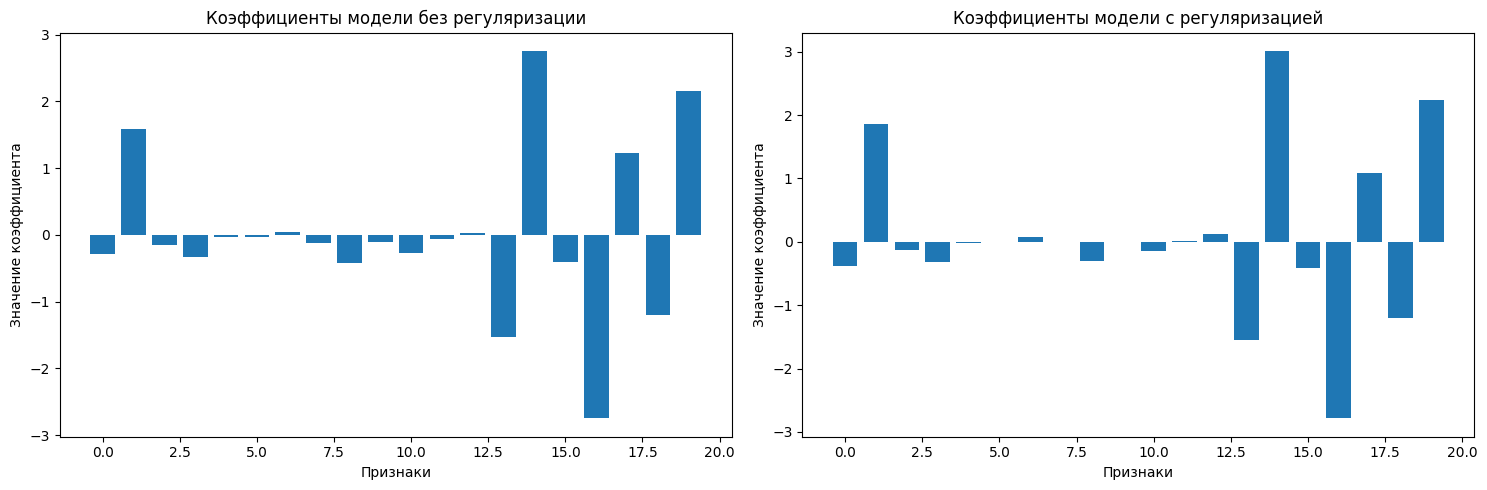

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed, Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed)

# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_embedded, Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [64]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.7508
Точность на тестовой выборке: 0.7533

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78       653
         1.0       0.74      0.71      0.72       547

    accuracy                           0.75      1200
   macro avg       0.75      0.75      0.75      1200
weighted avg       0.75      0.75      0.75      1200



### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**

### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [65]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [66]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [67]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [68]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:
k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy())


K-Fold Cross-Validation - Средняя точность: 0.7508333333333334
Точности по каждому фолду: [0.7608333333333334, 0.755, 0.7575, 0.7333333333333333, 0.7475]


### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [69]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=5, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

# Пример использования:
shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy())


ShuffleSplit Cross-Validation - Средняя точность: 0.7516666666666667
Точности по каждому разделению: [0.7508333333333334, 0.7595833333333334, 0.75375, 0.75375, 0.7404166666666666]


### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [70]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())


Точность на валидационных данных: 0.7633333333333333
Точность на тестовых данных: 0.76875


### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**